### Setup

In [1]:
import os, sys
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if path not in sys.path:
    sys.path.insert(0, path)

In [2]:
from models import dcn_mix_eq3 as DCN
from models import common as util
from models.common import np

import importlib
importlib.reload(DCN)
importlib.reload(util)

<module 'models.common' from '/home/castro/projects/learning-projects/machine_learning/dc_network/models/common.py'>

In [3]:
from autograd import grad
from autograd.misc.flatten import flatten

In [4]:
np.random.seed(123)
cfg = {
    'lr': 1e-3,
    'batch_size': 32,
    'num_iters_reg': 20000,
    'num_iters_mov': 5000,
}

### Regression

In [5]:
input_len = 5
def f(x):
    return x[0] * x[1] + x[4]**2

def gen_sample(batch_size):
    x = np.random.randn(input_len, batch_size)
    y = f(x)
    return x, y.reshape(-1, 1)

params = DCN.init_params(n_dense_features=input_len, l_ff=0)
params, unflatten = flatten(params)

In [6]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, target = gen_sample(batch_size=cfg['batch_size'])
    return util.mse(unflatten(params), DCN.predict, x_dense, [], target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss_val = objective(params, iter)
        print(f"Step: {iter:<5} | Loss: {loss_val:.6f}")

nw_params1 = adam(grad(objective), params, step_size=cfg['lr'], num_iters=cfg['num_iters_reg'], callback=callback)

callback(nw_params1, cfg['num_iters_reg'], None)

Step: 0     | Loss: 32.447446
Step: 500   | Loss: 8.718563
Step: 1000  | Loss: 4.925459
Step: 1500  | Loss: 7.946156
Step: 2000  | Loss: 1.165514
Step: 2500  | Loss: 1.547429
Step: 3000  | Loss: 0.850057
Step: 3500  | Loss: 0.525931
Step: 4000  | Loss: 0.976203
Step: 4500  | Loss: 0.538647
Step: 5000  | Loss: 0.537533
Step: 5500  | Loss: 0.504769
Step: 6000  | Loss: 0.218513
Step: 6500  | Loss: 0.147461
Step: 7000  | Loss: 0.155321
Step: 7500  | Loss: 0.125864
Step: 8000  | Loss: 0.112213
Step: 8500  | Loss: 0.055358
Step: 9000  | Loss: 0.042300
Step: 9500  | Loss: 0.113852
Step: 10000 | Loss: 0.046492
Step: 10500 | Loss: 0.093047
Step: 11000 | Loss: 0.043631
Step: 11500 | Loss: 0.129263
Step: 12000 | Loss: 0.015435
Step: 12500 | Loss: 0.012967
Step: 13000 | Loss: 0.014380
Step: 13500 | Loss: 0.013698
Step: 14000 | Loss: 0.010769
Step: 14500 | Loss: 0.007291
Step: 15000 | Loss: 0.004282
Step: 15500 | Loss: 0.003199
Step: 16000 | Loss: 0.002246
Step: 16500 | Loss: 0.003548
Step: 17000 |

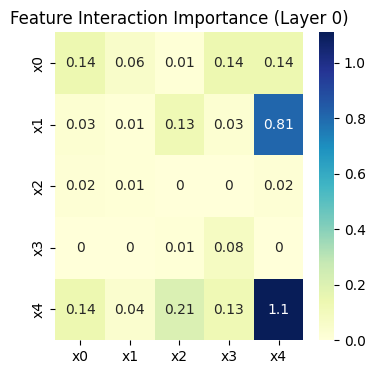

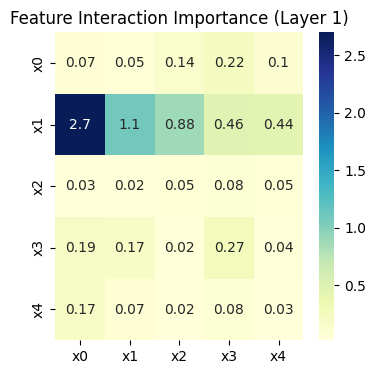

In [7]:
DCN.plot_heatmap(unflatten(nw_params1), 0)
DCN.plot_heatmap(unflatten(nw_params1), 1)
# x[0] * x[1] + x[4] ** 2

### MovieLens

In [8]:
import pandas as pd

df_ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df_users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

df = pd.merge(df_ratings, df_users, on='user_id')

# df = df.sample(frac=1).reset_index(drop=True) # shuffle

In [9]:
d_embeddings = []

df['age'] = df['age'] / 100.0

df['liked'] = (df['rating'] > 3.0).astype(int)

cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']

for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

In [10]:
print(df)

       user_id  item_id  rating  timestamp   age  gender  occupation  \
0          195      241       3  881250949  0.49       1          20   
1          185      301       3  891717742  0.39       0           6   
2           21      376       1  878887116  0.25       1          20   
3          243       50       2  880606923  0.28       1          19   
4          165      345       1  886397596  0.47       1           3   
...        ...      ...     ...        ...   ...     ...         ...   
99995      879      475       3  880175444  0.13       1          18   
99996      715      203       5  879795543  0.36       0           0   
99997      275     1089       1  874795795  0.21       1          18   
99998       12      224       2  882399156  0.47       1           3   
99999       11      202       3  879959583  0.28       0          13   

       zip_code  liked  
0           415      0  
1             0      0  
2           311      0  
3           591      0  
4         

In [11]:
cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']
dense_cols = ['age']
n_dense_features = len(dense_cols)

d_embeddings = []
for col in cat_cols:
    vocab_size = df[col].nunique()
    emb_size = int((vocab_size ** (1.0/4.0)) * 6)
    d_embeddings.append((vocab_size, emb_size))
    
print(f"Cat Cols: {cat_cols + ['age_bucket']}")
print(f"Embedding Sizes: {d_embeddings}")

Cat Cols: ['user_id', 'item_id', 'gender', 'occupation', 'zip_code', 'age_bucket']
Embedding Sizes: [(943, 33), (1682, 38), (2, 7), (21, 12), (795, 31)]


In [12]:
def gen_sample(batch_size = 1):
    idx = np.random.randint(0, len(df), size = (batch_size))
    batch = df.iloc[idx]
    x_cat = np.array(batch[cat_cols].values.T)
    x_dense = np.array(batch[dense_cols].values.T)
    y = np.array(batch['liked'].values).reshape(-1, 1)
    return x_dense, x_cat, y

input_len = n_dense_features + sum(emb_size for _, emb_size in d_embeddings)

params = DCN.init_params(n_dense_features=n_dense_features, d_embeddings=d_embeddings)
params, unflatten = flatten(params)

In [13]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, x_cat, target = gen_sample(batch_size=cfg['batch_size'])
    return util.logloss(unflatten(params), DCN.predict, x_dense, x_cat, target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss_val = objective(params, iter)

        x_dense, x_cat, target = gen_sample(batch_size=1000)
        auc = util.aucscore(unflatten(params), DCN.predict, x_dense, x_cat, target)
        
        print(f"Step: {iter:<5} | LogLoss: {loss_val:.6f} | AUC: {auc:.6f}")

nw_params3 = adam(grad(objective), params, step_size=cfg['lr'], num_iters=cfg['num_iters_mov'], callback=callback)

callback(nw_params3, cfg['num_iters_mov'], None)

Step: 0     | LogLoss: 0.692853 | AUC: 0.482190
Step: 500   | LogLoss: 0.596792 | AUC: 0.739879
Step: 1000  | LogLoss: 0.608474 | AUC: 0.756008
Step: 1500  | LogLoss: 0.486703 | AUC: 0.782647
Step: 2000  | LogLoss: 0.542649 | AUC: 0.775538
Step: 2500  | LogLoss: 0.634865 | AUC: 0.811037
Step: 3000  | LogLoss: 0.574816 | AUC: 0.800501
Step: 3500  | LogLoss: 0.576454 | AUC: 0.801093
Step: 4000  | LogLoss: 0.474466 | AUC: 0.792448
Step: 4500  | LogLoss: 0.472539 | AUC: 0.794117
Step: 5000  | LogLoss: 0.507643 | AUC: 0.813901


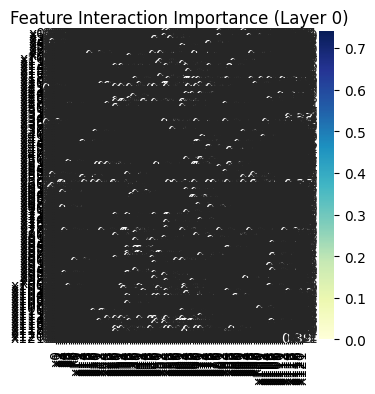

In [14]:
DCN.plot_heatmap(unflatten(nw_params3), 0)